In [1]:
import pandas as pd
import numpy as np
import ipaddress
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from river import metrics
from msStream import MsStream
from sklearn.covariance import EllipticEnvelope
from river.anomaly import QuantileFilter

## Load Data

In [2]:
def load_data (path):
    data = pd.read_csv(path, header=None)
    return data

In [3]:
data = load_data('UNSW-NB15_1.csv')

C:\Users\asmif\AppData\Local\Temp\ipykernel_536\1749990402.py:2: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, header=None)


In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


## Preprocessing

In [6]:
data.dtypes.value_counts()

int64      31
float64    10
object      8
dtype: int64

In [7]:
#Checking Missing Data
(data.isnull().sum()).sort_values(ascending=False)

47    677786
0          0
36         0
27         0
28         0
29         0
30         0
31         0
32         0
33         0
34         0
35         0
37         0
25         0
38         0
39         0
40         0
41         0
42         0
43         0
44         0
45         0
46         0
26         0
24         0
1          0
23         0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
48         0
dtype: int64

In [8]:
# column 47 has almost only nan values
data = data.drop(columns=47, axis=1)

In [9]:
# Seperating the target from data
X, y = data.drop(columns=48, axis=1), data.iloc[:,47]

In [10]:
# cleaning messy columns : 1 and 3
indexes = X[X[1]=='-'].index
X.drop(index= indexes, axis=0, inplace=True)
y.drop(index= indexes, axis=0, inplace=True)
X[1] = X[1].apply(lambda x : int(x, 16) if type(x)==str else x)

indexes = X[X[3]=='-'].index
X.drop(index= indexes, axis=0, inplace=True)
y.drop(index= indexes, axis=0, inplace=True)
X[3] = X[3].apply(lambda x : int(x, 16) if type(x)==str else x)

In [11]:
# getting categorical and numerical features
names_cat = []
for col in X.select_dtypes('object'): 
    names_cat.append(col)

names = X.columns.to_list()
names_num = list(set(names) - set(names_cat))

In [12]:
#converting an IP string to integer
X[0] = X[0].apply(lambda x : int(ipaddress.ip_address(x)))
X[2] = X[2].apply(lambda x : int(ipaddress.ip_address(x)))

#frequency encoding
for col in X.select_dtypes('object'):
    X[col] = X[col].map(X[col].value_counts().to_dict())

## MStream

### Fixed threshold

In [13]:
def normalize(y):
    return (y-min(y))/(max(y)-min(y))

In [14]:
def logits(y):
    return y>0.8

In [15]:
ms = MsStream(2, 1024, 0.4)
for i in range(1000):
    ms.learn_one(X.iloc[i], names_cat, names_num,X.iloc[i][29])

In [16]:
y_pred = [] 
for i in range(0,10000):
    ms.learn_one(X.iloc[i], names_cat, names_num,X.iloc[i][29])
    y_pred.append(ms.score_one(X.iloc[i], names_cat, names_num,X.iloc[i][29]))

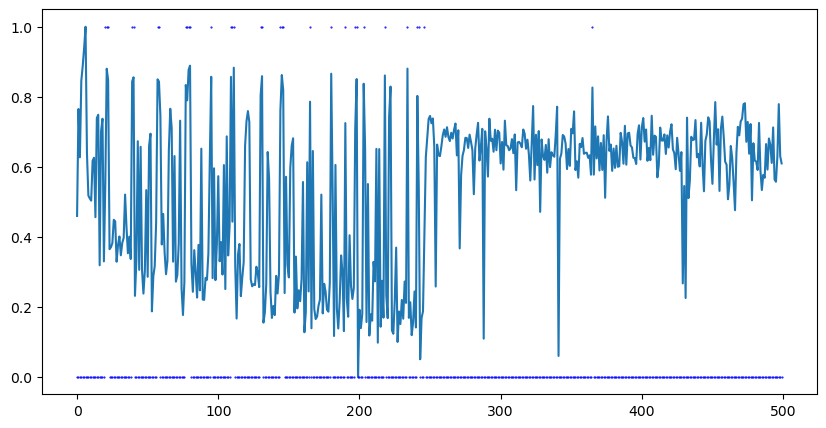

In [24]:
plt.figure(figsize=(10,5))
plt.plot(normalize(y_pred[:500]))
plt.plot(y[:500],'bo',ms=0.5)

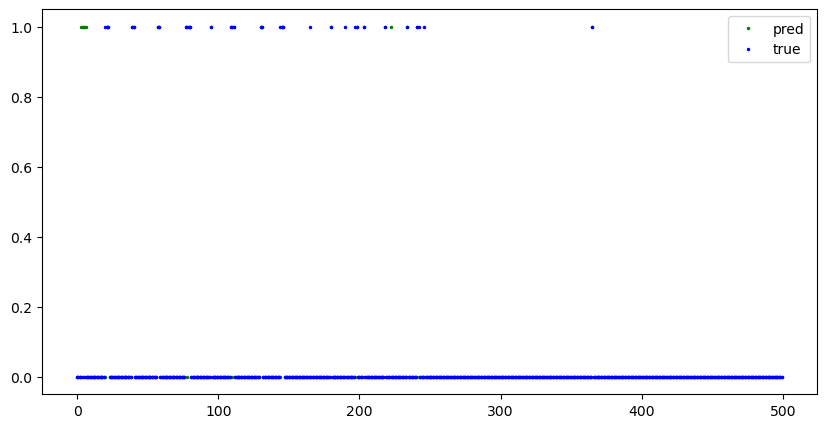

In [23]:
plt.figure(figsize=(10,5))
plt.plot(logits(normalize(y_pred[:500])),'go',ms=1.5,label="pred")
plt.plot(y[:500],'bo',ms=1.5,label='true')
plt.legend()

In [61]:
fpr, tpr, _ = roc_curve(np.array(y[:10000].values.flatten()),(normalize(y_pred[:10000])))
auc_score = roc_auc_score(y[:10000], (normalize(y_pred[:10000])))
print("auc_score = ",auc_score )

auc_score =  0.9225989318903675


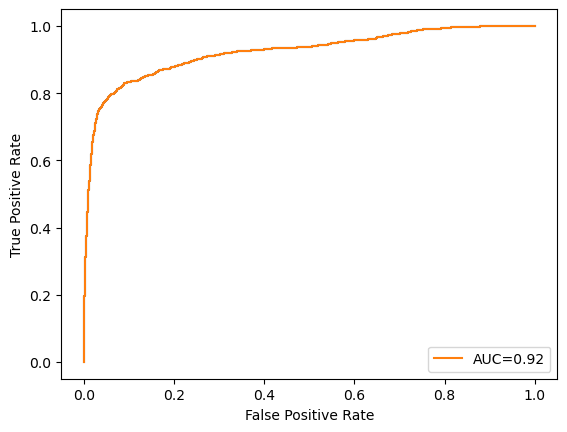

In [62]:
#create ROC curve
plt.plot(fpr,tpr,label="AUC={:.2f}".format(auc_score))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [63]:
acc = metrics.Accuracy()
kappa = metrics.CohenKappa()
auc = metrics.ROCAUC()
report = metrics.ClassificationReport()

for i in range(0,1000):
  # # make a prediction
  y_pred = logits(normalize(y_pred[:1000]))*1
  # Update metrics and results
  acc.update(y[i], y_pred[i])
  kappa.update(y[i], y_pred[i])
  auc.update(y[i], y_pred[i])
  report.update(y[i], y_pred[i])

In [64]:
print(acc)
print(kappa)
print(auc)
print(report)

Accuracy: 97.00%
CohenKappa: 58.98%
ROCAUC: 81.92%
           Precision   Recall   F1       Support  
                                                  
       0      98.75%   98.13%   98.44%       965  
       1      56.10%   65.71%   60.53%        35  
                                                  
   Macro      77.42%   81.92%   79.48%            
   Micro      97.00%   97.00%   97.00%            
Weighted      97.26%   97.00%   97.11%            

                 97.00% accuracy                  


### Adaptative threshold

In [65]:
def logits_var (y, threshold):
    return y>threshold 

In [66]:
ms = MsStream(2, 1024, 0.4)
for i in range(1000):
    ms.learn_one(X.iloc[i], names_cat, names_num,X.iloc[i][29])

In [67]:
# MsStream with Adaptative threshold
ms = MsStream(2, 1024, 0.4)
y_preds = []
y_fin_ms_at = []
y_proba_ms_at = []
window_threshold = 50
threshold = 0.5
j = 0
for i in range(10000):
    ms.learn_one(X.iloc[i], names_cat, names_num,X.iloc[i][29])
    y_preds.append(ms.score_one(X.iloc[i], names_cat, names_num,X.iloc[i][29])) 
    if len(y_preds)% ((j+1)*window_threshold)==0 and y_preds:
        threshold = np.mean(normalize(y_preds[j*window_threshold:(j+1)*window_threshold]))+0.1
        y_fin_ms_at.extend(logits_var(normalize(y_preds[j*window_threshold:(j+1)*window_threshold]), threshold)*1)
        y_proba_ms_at.extend(normalize(y_preds[j*window_threshold:(j+1)*window_threshold]))
        j+= 1

In [68]:
# check the metrics on the model's predictions 
f1_ms_at = f1_score(y.iloc[:10000], y_fin_ms_at)
fpr_ms_at, tpr_ms_at, _ = roc_curve(y.iloc[:10000], y_proba_ms_at)
auc_score_ms_at = roc_auc_score(y.iloc[:10000], y_proba_ms_at)
report_ms_at = classification_report(y.iloc[:10000], y_fin_ms_at)

In [69]:
auc_score_ms_at

0.9075868346877072

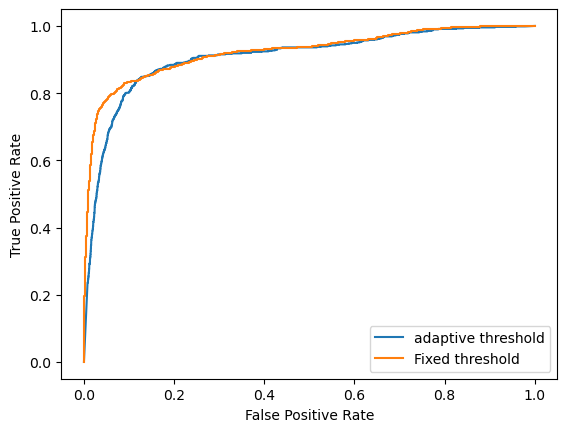

In [73]:
#create ROC curve
plt.plot(fpr_ms_at,tpr_ms_at,label="adaptive threshold")
plt.plot(fpr,tpr,label="Fixed threshold")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Mstream_PCA

In [75]:
#Scaling_data
scaler = MinMaxScaler()
New_X = pd.DataFrame(scaler.fit_transform(X[names_num]),columns = X[names_num].columns)

#PCA
pca = PCA(n_components=10)
New_X = pd.DataFrame(pca.fit_transform(New_X))

#getting data
New_X = pd.concat([New_X, X[names_cat].reset_index()],axis=1,join='inner',ignore_index=True)

In [76]:
ms = MsStream(2, 1024, 0.4)
for i in range(1000):
    ms.learn_one(New_X.iloc[i], list(range(10,10+len(names_cat))), list(range(10)),X.iloc[i][29])

In [77]:
y_pred_pca = [] 
for i in range(0,10000):
    ms.learn_one(New_X.iloc[i], list(range(10,10+len(names_cat))), list(range(10)),X.iloc[i][29])
    y_pred_pca.append(ms.score_one(New_X.iloc[i], list(range(10,10+len(names_cat))), list(range(10)),X.iloc[i][29]))

In [79]:
fpr_pca, tpr_pca, _ = roc_curve(np.array(y[:10000].values.flatten()),(normalize(y_pred_pca[:10000])))
auc_score = roc_auc_score(y[:10000], (normalize(y_pred_pca[:10000])))
print("auc_score = ",auc_score )

auc_score =  0.9668847142241979


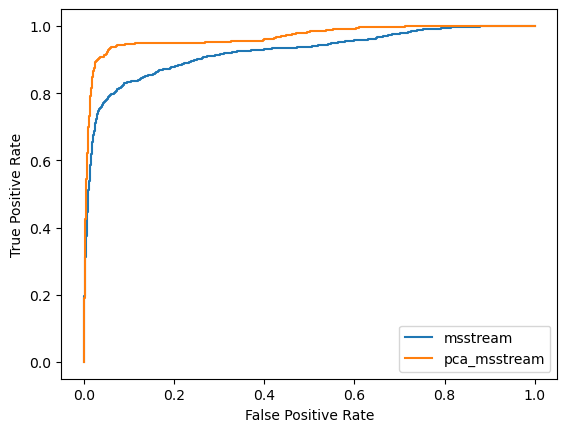

In [80]:
plt.plot(fpr,tpr,label="msstream")
plt.plot(fpr_pca,tpr_pca,label="pca_msstream")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [81]:
acc = metrics.Accuracy()
kappa = metrics.CohenKappa()
auc = metrics.ROCAUC()
report = metrics.ClassificationReport()

for i in range(0,10000):
  # # make a prediction
  y_pred_pca = logits(normalize(y_pred_pca[:10000]))*1
  # Update metrics and results
  acc.update(y[i], y_pred_pca[i])
  kappa.update(y[i], y_pred_pca[i])
  auc.update(y[i], y_pred_pca[i])
  report.update(y[i], y_pred_pca[i])

In [82]:
print(acc)
print(kappa)
print(auc)
print(report)

Accuracy: 95.82%
CohenKappa: 56.04%
ROCAUC: 71.22%
           Precision   Recall   F1       Support  
                                                  
       0      96.02%   99.65%   97.80%      9327  
       1      89.72%   42.79%   57.95%       673  
                                                  
   Macro      92.87%   71.22%   77.87%            
   Micro      95.82%   95.82%   95.82%            
Weighted      95.60%   95.82%   95.12%            

                 95.82% accuracy                  


## MStream_AE

In [95]:
scaler = MinMaxScaler()
New_X = pd.DataFrame(scaler.fit_transform(X[names_num]),columns = X[names_num].columns)

In [96]:
from keras.layers import Input, Dense
from keras.models import Model
# define the number of features
ncol = New_X.shape[1]

### Define the encoder dimension
encoding_dim = 10

input_dim = Input(shape = (ncol, ))

# Encoder Layers
encoded13 = Dense(encoding_dim, activation = 'relu')(input_dim)

# Decoder Layers
decoded13 = Dense(ncol, activation = 'sigmoid')(encoded13)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded13)

# Compile the Model
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')

In [97]:
autoencoder.fit(New_X, New_X, batch_size = 32, shuffle = False,validation_data = (New_X, New_X))

21875/21875 [==============================] - 47s 2ms/step - loss: 0.6400 - val_loss: 0.5547


In [98]:
encoder = Model(inputs = input_dim, outputs = encoded13)
encoded_input = Input(shape = (encoding_dim, ))

In [99]:
encoded_train = pd.DataFrame(encoder.predict(New_X))

21875/21875 [==============================] - 21s 936us/step


In [100]:
New_X = pd.concat([encoded_train, X[names_cat].reset_index()],axis=1,join='inner',ignore_index=True)

In [101]:
ms = MsStream(2, 1024, 0.4)
for i in range(1000):
    ms.learn_one(New_X.iloc[i], list(range(10,10+len(names_cat))), list(range(10)),X.iloc[i][29])

In [102]:
y_pred_ae = [] 
for i in range(0,15000):
    ms.learn_one(New_X.iloc[i], list(range(10,10+len(names_cat))), list(range(10)),X.iloc[i][29])
    y_pred_ae.append(ms.score_one(New_X.iloc[i], list(range(10,10+len(names_cat))), list(range(10)),X.iloc[i][29]))

In [103]:
fpr_ae, tpr_ae, _ = roc_curve(np.array(y[:15000].values.flatten()),(normalize(y_pred_ae[:15000])))
auc_score = roc_auc_score(y[:15000], (normalize(y_pred_ae[:15000])))
print("auc_score = ",auc_score )

auc_score =  0.9225049400488193


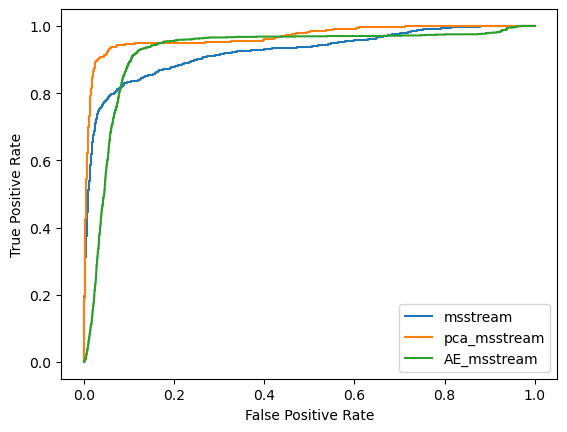

In [105]:
plt.plot(fpr,tpr,label="msstream")
plt.plot(fpr_pca,tpr_pca,label="pca_msstream")
plt.plot(fpr_ae,tpr_ae,label="AE_msstream")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## EllipticEnvelope

In [111]:
# instantiate model
model1 = EllipticEnvelope(contamination = 0.37) 
pred_ee = model1.fit_predict(X)
pred_ee[pred_ee==1]=0
pred_ee[pred_ee==-1]=1

c:\Users\asmif\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


In [112]:
proba_ee = model1.decision_function(X)
proba_ee = 1 - proba_ee
proba_ee = (proba_ee-min(proba_ee))/(max(proba_ee)-min(proba_ee))

In [113]:
f1_ee = f1_score(y, pred_ee)
fpr_ee, tpr_ee, _ = roc_curve(y, proba_ee)
auc_score_ee = roc_auc_score(y, proba_ee)
report_ee = classification_report(y, pred_ee)

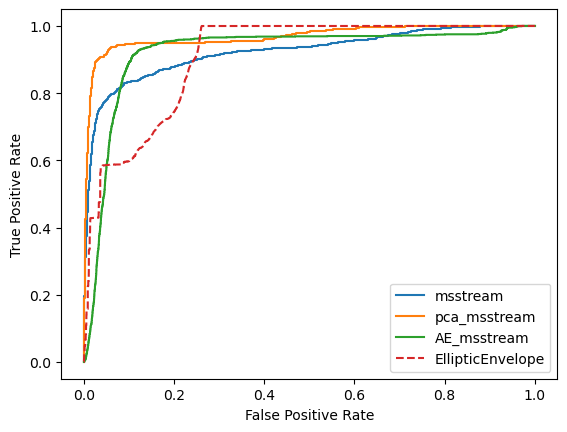

In [116]:
plt.plot(fpr,tpr,label="msstream")
plt.plot(fpr_pca,tpr_pca,label="pca_msstream")
plt.plot(fpr_ae,tpr_ae,label="AE_msstream")
plt.plot(fpr_ee,tpr_ee,"--",label="EllipticEnvelope")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## QuantileFilter

In [124]:
model = QuantileFilter(MsStream(2, 1024, 0.4), q=0.65)

In [126]:
# MsStream with Adaptative threshold
ms = MsStream(2, 1024, 0.4)
y_preds = []
y_fin_ms_qt = []
y_proba_ms_qt = []
window_threshold = 50
threshold = 0.5
j = 0
for i in range(10000):
    model.anomaly_detector.learn_one(X.iloc[i], names_cat, names_num,X.iloc[i][29])
    model.learn_one(X.iloc[i], names_cat, names_num,X.iloc[i][29])
    y_pred = model.anomaly_detector.score_one(X.iloc[i], names_cat, names_num,X.iloc[i][29])
    y_preds.append(y_pred) 
    if len(y_preds)% ((j+1)*window_threshold)==0 and y_preds:
        y_fin_ms_qt.extend([model.classify(y_preds[k]) for k in range(j*window_threshold,(j+1)*window_threshold)])
        y_proba_ms_qt.extend(normalize(y_preds[j*window_threshold:(j+1)*window_threshold]))
        j+= 1

In [127]:
# check the metrics on the model's predictions 
f1_ms_qt = f1_score(y.iloc[:10000], y_fin_ms_qt)
fpr_ms_qt, tpr_ms_qt, _ = roc_curve(y.iloc[:10000], y_proba_ms_qt)
auc_score_ms_qt = roc_auc_score(y.iloc[:10000], y_proba_ms_qt)
report_ms_qt = classification_report(y.iloc[:10000], y_fin_ms_qt)

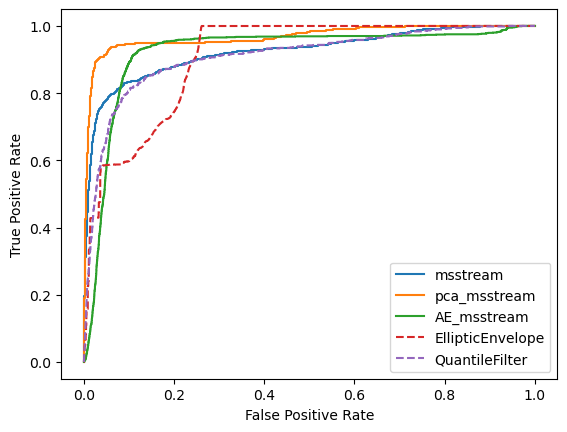

In [130]:
plt.plot(fpr,tpr,label="msstream")
plt.plot(fpr_pca,tpr_pca,label="pca_msstream")
plt.plot(fpr_ae,tpr_ae,label="AE_msstream")
plt.plot(fpr_ee,tpr_ee,"--",label="EllipticEnvelope")
plt.plot(fpr_ms_qt,tpr_ms_qt,"--",label="QuantileFilter")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()